In [225]:
import numpy as np
import matplotlib.pyplot as plt

In [226]:
from pathlib import Path
import sys

try:
    ROOT = Path().resolve().parents[1]
    assert (ROOT / "common").exists()
except AssertionError:
    ROOT = next(p for p in Path().resolve().parents if (p / "common").exists())

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

In [227]:
#print(ROOT)

In [228]:
from common import sensors as sn 
from common import subspace_methods as sm
from common import em_tools as em
from common import log_funcs as lf

In [229]:
DIST_RATIO = 0.5

In [230]:
Num_sensors1 = 25
Num_emitters1 = 1
sample_size1 = 12

failing_sensors1 = np.arange(10)
gap_ratio1 = 0.5 * np.ones_like(failing_sensors1, dtype=np.float32)

theta1_rad = np.array([0.7]) # Угловые координаты источников (DoA) в радианах
theta1_deg = np.rad2deg(theta1_rad) # Угловые координаты источников (DoA) в градусах

signal_dB = -3
noise_dB = 9

signal_var = sn.db_to_var(signal_dB)
noise_var = sn.db_to_var(noise_dB)

P1 = signal_var * np.eye(Num_emitters1, dtype=np.float64) # Ковариация сигналов
Q1 = noise_var * np.eye(Num_sensors1, dtype=np.float64) # Ковариация шумов

#P1 = 0.5 * np.eye(Num_emitters1, dtype=np.float64) # Ковариация сигналов
#Q1 = 8.1 * np.eye(Num_sensors1, dtype=np.float64) # Ковариация шумов

A1 = (np.exp(-2j * np.pi * DIST_RATIO * np.arange(Num_sensors1).reshape(-1,1) * 
             np.sin(theta1_rad))) # Матрица векторов направленности
# Генерация сигналов, шумов и наблюдений
S1 = sn.gss(Num_emitters1, sample_size1, P1)
N1 = sn.gss(Num_sensors1, sample_size1, Q1)
X1 = (A1 @ S1.T + N1.T).T
X1_with_mv = sn.MCAR(X1, failing_sensors1, gap_ratio1)
R1 = sn.initial_Cov(X1_with_mv)
MUSIC_theta1 = sm.MUSIC_DoA(R1, Num_emitters1)
#MUSIC_theta1 = np.array([0.68])

In [231]:
MUSIC_theta1

array([0.71558499])

In [232]:
sn.SNR(A1, P1, Q1, metrics = 'avg', scale = 'linear')

np.float64(1.5773933612004833)

In [233]:
EM_theta1_rad, EM_P1, lhd_1, lhd_list1, angles_list1 = em.multistart_EM(X1_with_mv, 
                                                                        Num_emitters1, 
                                                                        Q=Q1,
                                                                        theta_guess=MUSIC_theta1, 
                                                                        num_of_starts=1, 
                                                                        max_iter=50, 
                                                                        rtol_params=1e-6,
                                                                        rtol_lkhd=1e-6,
                                                                        reg_coef=1e-5)

0-th start
theta=[0.71558499],P=[[9.52396052e-08-9.92616735e-25j]]
Inital likelihood = -769.0765271449704
Iteration=1
new_angles=[0.71558499]
likelihood is -769.0756469366279 on iteration 1.
Iteration=2
new_angles=[0.71171286]
likelihood is -769.0746994446301 on iteration 2.
Iteration=3
new_angles=[0.70922905]
likelihood is -769.073732181218 on iteration 3.
Iteration=4
new_angles=[0.70675051]
likelihood is -769.0727418357712 on iteration 4.
Iteration=5
new_angles=[0.70510566]
likelihood is -769.0717552527965 on iteration 5.
Iteration=6
new_angles=[0.70382722]
likelihood is -769.0707682390739 on iteration 6.
Iteration=7
new_angles=[0.70281244]
likelihood is -769.0697808919718 on iteration 7.
Iteration=8
new_angles=[0.70179854]
likelihood is -769.0687890295394 on iteration 8.
Iteration=9
new_angles=[0.7007855]
likelihood is -769.0677938819846 on iteration 9.
Iteration=10
new_angles=[0.70042553]
likelihood is -769.0668047215343 on iteration 10.
Iteration=11
new_angles=[0.70006566]
likelih

In [234]:
EM_theta1_rad, EM_P1

(array([0.6983251]), array([[0.00076647+0.j]]))

In [235]:
lf.incomplete_lkhd(X1_with_mv, EM_theta1_rad, EM_P1, Q1), lf.incomplete_lkhd(X1_with_mv, theta1_rad, P1, Q1)

(np.float64(-769.0025402131914), np.float64(-751.4250665632064))

In [236]:
lhd_list1 = np.array(lhd_list1)
angles_list1 = np.rad2deg(np.array(angles_list1))
x1 = np.arange(len(angles_list1))

In [237]:
x_grid = np.arange(1,50,5)

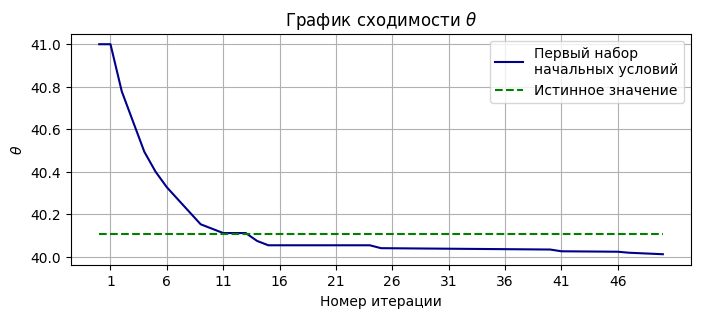

In [238]:
plt.figure(figsize=(8, 3))
plt.title(r'$\text{График сходимости} \,\,\theta$')
plt.plot(x1, angles_list1,color='darkblue', label=f'Первый набор\nначальных условий')
plt.plot(x1, np.tile(theta1_deg, len(angles_list1)), color='green', label='Истинное значение', linestyle='--')
plt.xlabel('Номер итерации') 
plt.ylabel(r'$\theta$')
plt.xticks(x_grid)
plt.legend()
plt.grid()
plt.show()

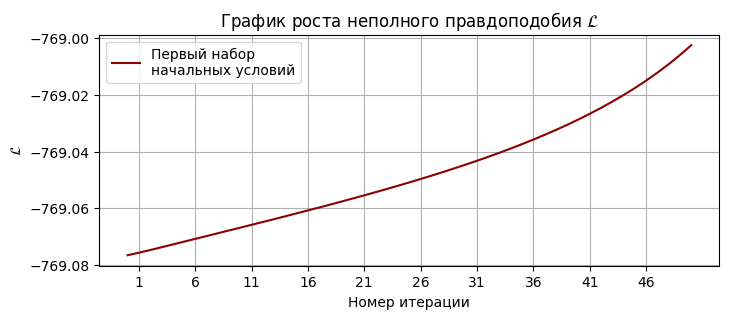

In [239]:
plt.figure(figsize=(8, 3))
plt.title(r'$\text{График роста неполного правдоподобия} \,\,\mathcal{L}$')
plt.plot(x1, lhd_list1, color='darkred', label=f'Первый набор\nначальных условий')
plt.xlabel('Номер итерации') 
plt.ylabel(r'$\mathcal{L}$')
plt.xticks(x_grid)
plt.legend()
plt.grid()
plt.show()